# CMS28 Smart Pix NN

Disable some console warnings

In [18]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Import libraries

In [19]:
# Standard library imports
import math

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

# TensorFlow imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import random
# QKeras imports
from qkeras import *

# Local imports
from hep_utils import plot_pt_filter, get_number_of_tracks, get_bkg_rej
from utils import *
from utils_GDG import *


# Magic commands
#%matplotlib inline

## Prepare dataset

### Load dataset

#### ds8

`dataset 8`

#### ds8q

`dataset 8` and the 14th column is distributed on the range `[0,11]`

#### ds8-local

`dataset 8` but split for _each local bin_

<p style="background-color:Yellow;"><b>Choose the local bin (y-local).</b></p>

In [20]:
local_id = 6 # 0 - 11

<p style="background-color:Yellow;"><b>Run identifier.</b></p>

In [21]:
run_id = 0

In [22]:
# Set random seeds for reproducibility
random_numbers = [11,13,17,19,23,29,31,37,41,43,47,53]
seed = random_numbers[run_id] #
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# dataset = 'ds8l{}_'.format(local_id)
# base_dir = 'data/ds8_only'
dataset= 'tmp_'
save_dir = f'tmp_NoiseXe-/noiseTrainedModels/model{run_id}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(save_dir+'/images')
    os.makedirs(save_dir+'/csv')
    os.makedirs(save_dir+'/models')
base_dir = './'
base_dir2 = '/fasic_home/gdg/research/projects/CMS_PIX_28/directional-pixel-detectors/multiclassifier/data/ds8_only'

# pt_data = '{}/dec6_ds8_quant/TestSetTruePTLocal{}.csv'.format(base_dir, local_id)

# train on yprofile from ds14 chip results
# train_data = '/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.09.30_19.35.25_DNN_vth0-0.048_vth1-0.083_vth2-0.128/yprofiles.csv'
# train_label = '{}/tmp_21x13/1000_1600_2400/clslabels.npy'.format(base_dir)

# headers = [str(i) for i in range(0, 16)]
# df1 = pd.read_csv(train_data, header=None, names=headers)
# df2 = pd.DataFrame(np.load(train_label)[:10000])
# # df2 = pd.read_csv(train_label)
# df3 = pd.read_csv(test_data)
# df4 = pd.read_csv(test_label)

# train on quantized dataset (created at FNAL)
train_data = '{}/dataset_8_0NoiseThresh/FullPrecisionInputTrainSet_50x12P5_0P2thresh.csv'.format(base_dir)
train_label = '{}/dataset_8_0NoiseThresh/TrainSetLabel_50x12P5_0P2thresh.csv'.format(base_dir)
test_data = '{}/dec6_ds8_quant/QuantizedInputTestSetLocal{}.csv'.format(base_dir2, local_id)
test_label = '{}/dec6_ds8_quant/TestSetLabelLocal{}.csv'.format(base_dir2, local_id)

# original:
# train_data = '{}/dec6_ds8_quant/QuantizedInputTrainSetLocal{}.csv'.format(base_dir, local_id)
# train_label = '{}/dec6_ds8_quant/TrainSetLabelLocal{}.csv'.format(base_dir, local_id)
# test_data = '{}/dataset_8_0NoiseThresh/FullPrecisionInputTestSet_50x12P5_0P2thresh.csv'.format(base_dir)
# test_label = '{}/dataset_8_0NoiseThresh/TestSetLabel_50x12P5_0P2thresh.csv'.format(base_dir)

pt_data = '{}/dataset_8_0NoiseThresh/TestSetPt_50x12P5_0P2thresh.csv'.format(base_dir)

df1 = pd.read_csv(train_data)
df2 = pd.read_csv(train_label)
df3 = pd.read_csv(test_data)
df4 = pd.read_csv(test_label)


### Pad dataset

In [23]:
padding = ""

<p style="background-color:Tomato;"><b>DO NOT USE A PADDED DATASET TO TRAIN AND EVALUATE A MODEL! Padding a dataset is useful only to generate a "larger" accelerator in the synthesis flow.</b></p>

Enable following cell to enable padding.

In [24]:
padding = "padded_"

if '14' not in df1.columns and 14 not in df1.columns:
    df1['14'] = 0
    df1['15'] = 0
    df1['16'] = 0

if '14' not in df3.columns and 14 not in df3.columns:
    df3['14'] = 0
    df3['15'] = 0
    df3['16'] = 0

## Inject noise into datasets

In [25]:
inject_noise=True

In [26]:
# Copied from https://github.com/smart-pix/pretrain-data-prep/blob/main/dataset_utils.py on September 30, 2025
from copy import deepcopy

def add_noise(x, mu = 0, sig = 400, shuffled = True, seed = None):
    '''
    Add random gaussian noise to input data 
        x (np.array or pd.DataFrame): input data with dims (event, time, 2d image)
        mu (float): mean of noise 
        sig (float): standard deviation of noise
        shuffled (bool): was the dataset megashuffled? ie. are the labels and data both present in the df?
        seed (None, int): seed for reproducable random noise sampling. Set to None to disable
    '''
    df = deepcopy(x)
    if shuffled:
        cols = [c for c in x.columns if c.isnumeric()]
        data = df[cols]
    else:
        data=df
    
    dshape = data.shape
    
    rng = np.random.default_rng(seed = seed)
    noise = rng.normal(mu, sig, dshape)

    # if integrate: #DEPRECIATED
    #     noise = np.cumsum(noise, axis = 1)
    data = data + noise
    if cols:
        df[cols] = data
    else:
        df = data
    return df

def quantize_manual(x, 
                    charge_levels=[400, 1600, 2400], 
                    quant_values=[0,1,2,3], 
                    shuffled=True
                   ):
    '''
    Quantize a df with manually defined charge level boundaries
        x (np.array or pd.DataFrame): input data (with or without labels).
        charge_levels (list, shape=(N-1)): finite charge levels for boundaries of N bins. 
            eg. for N=4 bins with boundaries [-9e19, 400], [400, 800], [800,1200], [1200, 9e19]
            use: charge_levels = [400, 800, 1200]
        quant_values (list): list of values for each of N charge bins
        shuffled (bool, default: True): is this dataframe from a dataset shuffled? ie. are
            clusters and labels both present in the dataframe x
    '''
    # start_time = time.time()
    df = deepcopy(x)
    if shuffled: 
        cols = [c for c in df.columns if c.isnumeric()]
        data = df[cols].values
    else:
        data = df.values
    # print(f'get data: {time.time()-start_time:.4f}', f'total: {time.time()-start_time:.4f}')
    # newtime = time.time()
    charge_levels= np.array(charge_levels)
    minval, maxval = [-9e19], [9e19]

    #pad the charge levels with +/- inf
    charge_levels = np.append(minval, charge_levels)
    charge_levels= np.append(charge_levels, maxval)

    #turn charge_levels into bin boundaries
    bins = None
    for c in range(len(charge_levels)-1):
        if bins is None:
            bins = [[charge_levels[c], charge_levels[c+1]]]
        else:
            bins = np.append(bins, [[charge_levels[c], charge_levels[c+1]]], axis =0)
    # print(f'make bins: {time.time()-newtime:.4f}', f'total: {time.time()-start_time:.4f}')
    # newtime = time.time()

    #quantize the data
    dfq = pd.DataFrame(np.zeros_like(data),index=df.index, columns=cols)
    for j, binbounds in enumerate(bins):
        #mask pixels by charge bin
        mask = (data>binbounds[0]) & (data<binbounds[1])
        dfq = dfq.mask(mask, quant_values[j])
    if shuffled:
        df[cols] = dfq
    else:
        df = dfq
    # print(f'make quantized data: {time.time()-newtime:.4f}', f'total: {time.time()-start_time:.4f}')

    try:
        return df
    finally:
        del dfq, data, mask, df, cols

if inject_noise == True:
    df1_copy = df1.copy()
    df3_copy = df3.copy()
    df1_copy.loc[:, :] = 0
    df3_copy.loc[:, :] = 0
    df1_copy = add_noise(df1_copy, sig = 2400, shuffled = True)
    df3_copy = add_noise(df3_copy, sig = 2400, shuffled = True)
    df1_copy = quantize_manual(df1_copy, charge_levels=[400, 1600, 2400], quant_values=[0,1,2,3], shuffled=True)
    df3_copy = quantize_manual(df3_copy, charge_levels=[400, 1600, 2400], quant_values=[0,1,2,3], shuffled=True)
    print("Before noise-injection:", df3.head())
    df1 = df1 + df1_copy
    df3 = df3 + df3_copy
    print("After noise-injection:", df3.head())


Before noise-injection:    0  1  2   3   4   5  6  7  8  9  10  11  12  14  15  16
0  0  0  5  15  15   7  0  0  0  0   0   0   0   0   0   0
1  0  0  0   0   0   7  7  0  0  0   0   0   0   0   0   0
2  0  0  0   4  18  12  0  0  0  0   0   0   0   0   0   0
3  0  0  0   5  10   3  0  0  0  0   0   0   0   0   0   0
4  0  0  0   0   5  14  9  0  0  0   0   0   0   0   0   0
After noise-injection:      0    1    2     3     4     5    6    7    8    9   10   11   12   14  \
0  0.0  0.0  5.0  16.0  15.0   7.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1  1.0  3.0  1.0   3.0   0.0   7.0  7.0  0.0  3.0  2.0  0.0  0.0  1.0  0.0   
2  1.0  0.0  1.0   5.0  18.0  12.0  2.0  1.0  0.0  3.0  0.0  0.0  0.0  1.0   
3  0.0  0.0  0.0   7.0  10.0   4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  1.0  0.0  0.0   0.0   5.0  15.0  9.0  2.0  1.0  0.0  2.0  3.0  0.0  0.0   

    15   16  
0  2.0  0.0  
1  0.0  1.0  
2  0.0  0.0  
3  1.0  0.0  
4  0.0  0.0  


/tmp/ipykernel_27699/652660973.py:95: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df1_copy.loc[:, :] = 0


In [27]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values

print(df1.head())
print('Training set shape         :', X_train.shape) 
print('Training set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)

     0    1    2     3    4    5    6    7    8    9   10   11   12   14   15  \
0  0.0  0.0  3.0   2.0  0.0  6.0  3.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0   
1  0.0  2.0  0.0   2.0  4.0  5.0  2.0  3.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  3.0  0.0  5.0  10.0  8.0  4.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  3.0  1.0   
3  0.0  0.0  0.0   5.0  3.0  4.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  1.0  1.0   
4  0.0  1.0  0.0   6.0  2.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    16  
0  0.0  
1  1.0  
2  0.0  
3  1.0  
4  0.0  
Training set shape         : (68000, 16)
Training set shape (labels): (68000, 1)
Test set shape:           : (13983, 16)
Test set shape (labels)   : (13983, 1)


### Visualize dataset

Observe the span of the value for each of the 14 columns. The 14th column -- if quantized -- should span on the range `[0,11]`.

In [28]:
frames = [df1, df3]

df = pd.concat(frames)

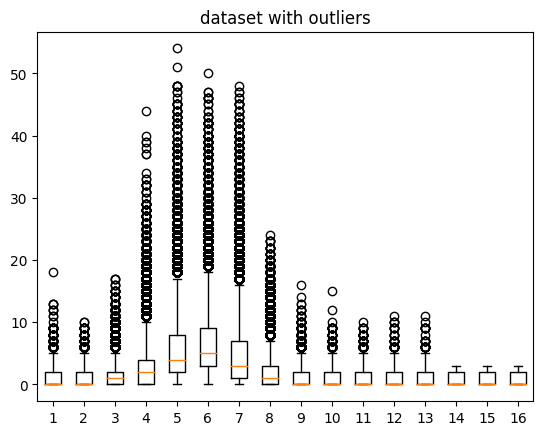

In [29]:
_ = plt.title("dataset with outliers")
_ = plt.boxplot(df.values, showfliers=True)

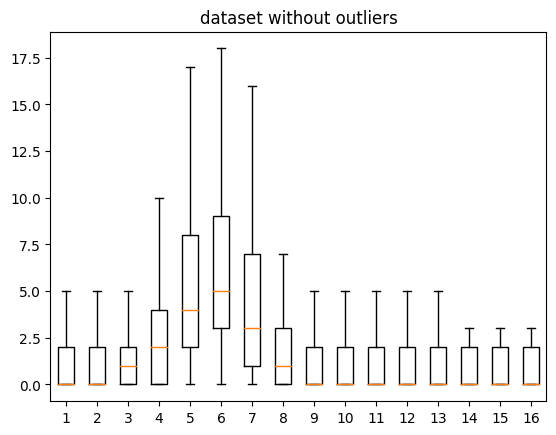

In [30]:
_ = plt.title("dataset without outliers")
_ = plt.boxplot(df.values, showfliers=False)

You should see all integers if you are using the `dataset 6-7-8` with 14th column quantized

In [31]:
pd.DataFrame(X_test[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,5.0,16.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
1,1.0,3.0,1.0,3.0,0.0,7.0,7.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,5.0,18.0,12.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,7.0,10.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,5.0,15.0,9.0,2.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,2.0,2.0,4.0,2.0,3.0,3.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0
6,1.0,3.0,0.0,3.0,1.0,1.0,7.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0
7,0.0,1.0,0.0,3.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0
8,0.0,3.0,1.0,3.0,3.0,13.0,14.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
9,1.0,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0


In [32]:
pd.DataFrame(y_test[:10])

,0
0,0
1,1
2,1
3,0
4,1
5,2
6,0
7,1
8,0
9,0


In [33]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 54.0 , log2(max)= 6 , min= 0.0
X_test: max= 51.0 , log2(max)= 6 , min= 0.0


### Scale dataset

<p style="background-color:Yellow;"><b>Disabling scaling will simplify the hardware design</b></p>

In [34]:
scale = False

In [35]:
scaling = ''
if scale:
    scaling = 'scaling_'
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
else:
    scaling = 'noscaling_'

#### Visualize dataset post-scaling

In [36]:
# pd.DataFrame(X_train).to_csv('csv/' + dataset + scaling + 'InputTrainSetScale.csv',index=False)
# pd.DataFrame(X_test).to_csv('csv/' + dataset + scaling + 'InputTestSetScale.csv',index=False)

In [37]:
pd.DataFrame(X_test[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,5.0,16.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
1,1.0,3.0,1.0,3.0,0.0,7.0,7.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,5.0,18.0,12.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,7.0,10.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,5.0,15.0,9.0,2.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,2.0,2.0,4.0,2.0,3.0,3.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0
6,1.0,3.0,0.0,3.0,1.0,1.0,7.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0
7,0.0,1.0,0.0,3.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,3.0
8,0.0,3.0,1.0,3.0,3.0,13.0,14.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
9,1.0,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0


In [38]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 54.0 , log2(max)= 6 , min= 0.0
X_test: max= 51.0 , log2(max)= 6 , min= 0.0


### One-hot encoding

In [39]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

# y_train_oh.to_csv("csv/" + dataset + "labelsTrainOH.csv",index=False)
# y_test_oh.to_csv("csv/" + dataset + "labelsTestOH.csv",index=False)

KeyError: 'ptLabel'

In [ ]:
display_side_by_side(pd.DataFrame(y_test[:10]), pd.DataFrame(y_test_oh[:10]), titles=['Prediction','One-hot encoding'])

### Save .dat files

In [ ]:
# !mkdir -p csv/pad/l$local_id
# pd.DataFrame(X_test).to_csv('csv/pad/l{:d}/tb_input_features.dat'.format(local_id), sep=' ', index=False)
# y_test_oh.to_csv('csv/pad/l{:d}/tb_output_predictions.dat'.format(local_id), sep=' ', index=False)

## Model (Keras)

Let's start with a Keras model that is more traditional and uses floating-point. Our goal is to eventually get a quantized model for QKeras and hls4ml that is _close enough_ to this initial model.

### Model definition

Define a few MLP models with different size and number of layers

In [40]:
models = {}

#### d128

This is our original model that we also use as a reference

In [41]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(128, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d128'] = {
    'prefix': dataset + padding + scaling + 'keras_d128',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d64

In [42]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(64, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d64'] = {
    'prefix': dataset + padding + scaling + 'keras_d64',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d60

In [43]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(60, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d60'] = {
    'prefix': dataset + padding + scaling + 'keras_d60',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d58

In [44]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(58, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d58'] = {
    'prefix': dataset + padding + scaling + 'keras_d58',
    'type'  : 'keras',
    'def'   : CreateModel}

### Model create and summary

Show the dictionary of models

In [45]:
print_dictionary(models)

d128
  prefix
    tmp_padded_noscaling_keras_d128
  type
    keras
  def
    <function CreateModel at 0x7faf2db51ee0>
d64
  prefix
    tmp_padded_noscaling_keras_d64
  type
    keras
  def
    <function CreateModel at 0x7faf2db50040>
d60
  prefix
    tmp_padded_noscaling_keras_d60
  type
    keras
  def
    <function CreateModel at 0x7faf2db50fe0>
d58
  prefix
    tmp_padded_noscaling_keras_d58
  type
    keras
  def
    <function CreateModel at 0x7faf2db537e0>


<p style="background-color:Yellow;"><b>Choose a model for training and testing</b></p>


In [46]:
#chosen_model = 'd64' # <<< PAY ATTENTION <<<
#chosen_model = 'd60' # <<< PAY ATTENTION <<<
chosen_model = 'd58' # <<< PAY ATTENTION <<<

In [47]:
model_prefix = models[chosen_model]['prefix']
model_def = models[chosen_model]['def']
model_type = models[chosen_model]['type']

In [48]:
print(model_prefix)

tmp_padded_noscaling_keras_d58


In [49]:
print(y_train)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [58]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16)]              0         
                                                                 
 dense1 (Dense)              (None, 58)                986       
                                                                 
 batch_normalization_1 (Bat  (None, 58)                232       
 chNormalization)                                                
                                                                 
 relu1 (Activation)          (None, 58)                0         
                                                                 
 dense2 (Dense)              (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                           

### Model training

In [59]:
train_and_save = True # <<< PAY ATTENTION <<<

In [60]:
model_file = save_dir+ '/models/' + model_prefix + 'model_0.h5'
# model_file = save_dir+ '/models/' + model_prefix + 'model_' + str(run_id) + '.h5' # commented because all models are stored in separate folders per run_id

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=512,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

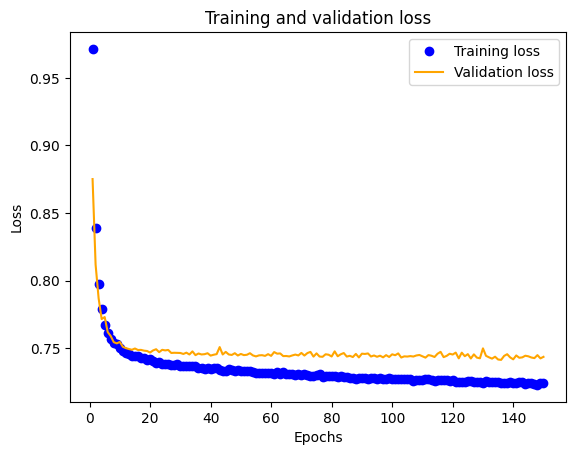

In [61]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_dir + '/images/' + model_prefix + '_loss.png')
else:
    from PIL import Image

    img = Image.open(save_dir + '/images/' + model_prefix + '_loss.png')
    display(img)

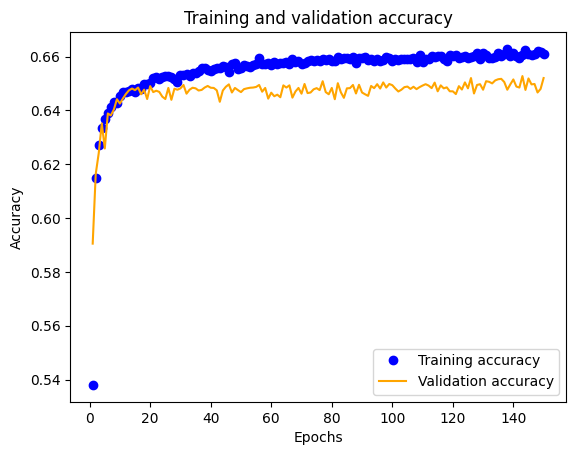

In [62]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig(save_dir + '/images/' + model_prefix + '_accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open(save_dir + '/images/' + model_prefix + '_accuracy.png')
    display(img)

In [63]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

437/437 [==============================] - 0s 832us/step


In [64]:
pd.DataFrame(predictionsFiles).to_csv(save_dir+'/csv/' + model_prefix + '_predictionsFiles.csv', header='predict', index=False)

In [65]:
pd.DataFrame(y_test).to_csv(save_dir+ '/csv/' + model_prefix + '_true.csv', header='true', index=False)
print(save_dir+'/csv/' + model_prefix + '_true.csv')

tmp_NoiseXe-/noiseTrainedModels/model0/csv/tmp_padded_noscaling_keras_d58_true.csv


In [66]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))

Test loss (Keras) d58: 0.7446897029876709
Test accuracy (Keras) d58: 0.644711434841156


Confusion matrix:
[[5339  739  791]
 [1466 2049   63]
 [1882   27 1627]]


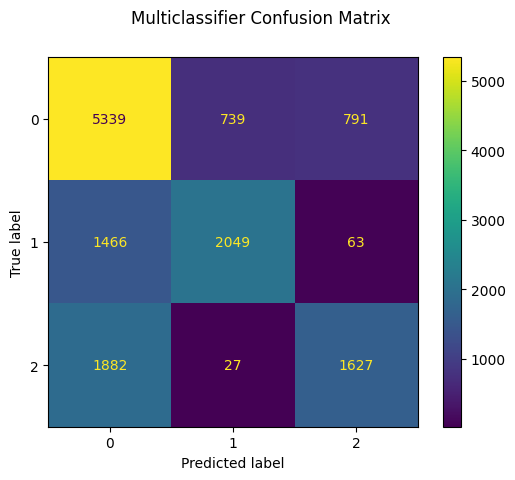

In [67]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(save_dir+'/images/' + model_prefix + '_confusionMatrix.png')
plt.show()

Besides ML accuracy, we can evaluate the model with a metric that is closer to the physical application. We use _the number of tracks that are greater of 1.0 GeV and that are correctly classified as high pT_.

In [68]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + model_type + '_' + chosen_model, pt_data)

FileNotFoundError: [Errno 2] No such file or directory: './csv/tmp_padded_noscaling_keras_d58_true.csv'

In [ ]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0, '<<<')
print('---')

In [ ]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + model_type + '_' + chosen_model, pt_data)

Summary of the results.

The model **id** is a label of the kind `dataset_scale_mltype_mlmodel`:
- `dataset` can be `ds7` (the original dataset) or `ds678` (the larger dataset with quantized 14th column)
- `scale` can be `scaling` (use standard scaler) or `noscaling` (don't scale)
- `mltype` can be `keras` (Keras), `qkeras` (QKeras), and `qkeras_foldbatchnorm` (QKeras + patch to fold batch normalization layer in the previous dense layer)
- `mlmodel` can be `d128`, `d64`, etc.

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

Current and previous results

In [ ]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [ ]:
print_results(results_filename)

Average results so far

In [ ]:
print_avg_results(results_filename)

In [ ]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    #'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    #'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )
print(id_ordering)
print(results_filename)

In [ ]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

In [ ]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q=None, predict_data_q=None, true_data_q=None,
               label_h=None, predict_data_h=None, true_data_h=None,
               output_image='images/' + model_prefix + '_turnonCurve.png',
               base_dir='.')

## Model (QKeras)

Mostly the same as the previous section, but now we are usin QKeras

### Model definition

In [69]:
qmodels = {}

#### qkeras-foldbatchnorm-d128w5a10

In [70]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d128w4a8

In [71]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w5a10

In [72]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w4a8

In [73]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w5a10

In [74]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w4a8

In [75]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w5a10

In [76]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(58,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w4a8

In [77]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    
    x = QDenseBatchnorm(58,
      kernel_quantizer=quantized_bits(4,0,alpha=1),
      bias_quantizer=quantized_bits(4,0,alpha=1),
      name="dense1")(x)
    # x = QDense(58,
    #      kernel_quantizer=quantized_bits(4,0,alpha=1),
    #      bias_quantizer=quantized_bits(4,0,alpha=1),
    #      name="dense1")(x)
    # x = keras.layers.BatchNormalization()(x)
    
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

### Model create and summary

In [78]:
print_dictionary(qmodels)

d128w5a10
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d128w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eaf20>
d128w4a8
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d128w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eae80>
d64w5a10
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d64w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eb420>
d64w4a8
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d64w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eb1a0>
d60w5a10
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d60w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eb240>
d60w4a8
  prefix
    tmp_padded_noscaling_qkeras_foldbatchnorm_d60w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7fae5f6eade0>
d58w5a10
  prefix
    tmp_padded_noscaling_qkeras_foldbatchn

<p style="background-color:Yellow;"><b>Choose a QKeras model for training and testing. Pay attention to the previously created model in Keras.</b></p>

In [79]:
print('Keras model:', chosen_model)

Keras model: d58


In [80]:
#chosen_qmodel = 'd64w5a10'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd64w4a8'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd60w5a10'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd60w4a8'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd58w5a10'  # <<< PAY ATTENTION <<<
chosen_qmodel = 'd58w4a8'  # <<< PAY ATTENTION <<<

In [81]:
qmodel_prefix = qmodels[chosen_qmodel]['prefix']
qmodel_def = qmodels[chosen_qmodel]['def']
qmodel_type = qmodels[chosen_qmodel]['type']

In [82]:
model = qmodel_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 16)]              0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 58)                1219      
                                                                 
 relu1 (QActivation)         (None, 58)                0         
                                                                 
 dense2 (QDense)             (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                                 
Total params: 1396 (5.46 KB)
Trainable params: 1279 (5.00 KB)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


### Model training

In [83]:
train_and_save = True # <<< PAY ATTENTION <<<

In [84]:
from qkeras.utils import model_save_quantized_weights

model_file = save_dir + '/models/' + qmodel_prefix + 'model_0.h5'
model_q_weights_file = save_dir + '/models/' + qmodel_prefix + 'model_q_weights_0.h5'
# model_file = save_dir + '/models/' + qmodel_prefix + 'model_' + str(run_id) + '.h5'  # commented because all models are stored in separate folders per run_id
# model_q_weights_file = save_dir + '/models/' + qmodel_prefix + 'model_q_weights_' + str(run_id) + '.h5'  # commented because all models are stored in separate folders per run_id

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model_save_quantized_weights(model, model_q_weights_file)
    model.save(model_file)
    print('Save:', model_file)
    print('Save:', model_q_weights_file)

co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

... quantizing model
dense1  conv and batchnorm weights cannot be seperately quantized because they will be folded before quantization.
Save: tmp_NoiseXe-/noiseTrainedModels/model0/models/tmp_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model_0.h5
Save: tmp_NoiseXe-/noiseTrainedModels/model0/models/tmp_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model_q_weights_0.h5


/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model evaluation

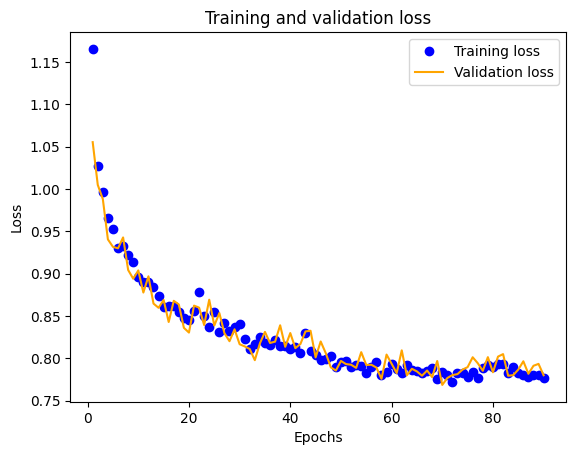

In [85]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_dir+'/images/' + qmodel_prefix + '_loss.png')
else:
    from PIL import Image

    img = Image.open(save_dir+'/images/' + qmodel_prefix + '_loss.png')
    display(img)

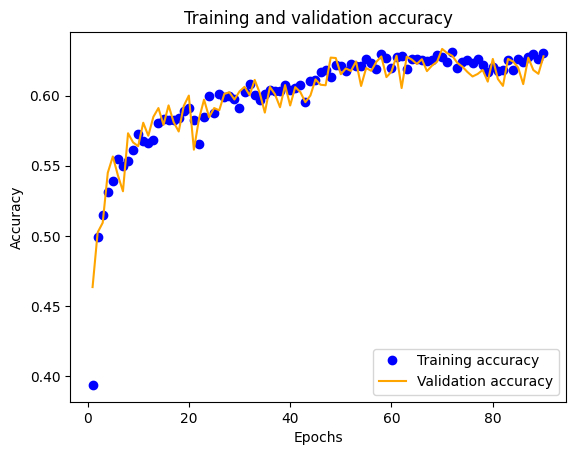

In [86]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig(save_dir+'/images/' + qmodel_prefix + '_accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open(save_dir+'/images/' + qmodel_prefix + '_accuracy.png')
    display(img)

In [87]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

437/437 [==============================] - 1s 1ms/step


In [88]:
pd.DataFrame(predictionsFiles).to_csv(save_dir+"/csv/" + qmodel_prefix + "_predictionsFiles.csv", header='predict', index=False)

In [89]:
pd.DataFrame(y_test).to_csv(save_dir+"/csv/" + qmodel_prefix + "_true.csv", header='true', index=False)

In [90]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (QKeras) {}: {}".format(chosen_model, score[1]))

Test loss (QKeras) d58: 0.7731240391731262
Test accuracy (QKeras) d58: 0.6321962475776672


Confusion matrix:
[[5141  786  942]
 [1507 2001   70]
 [1816   22 1698]]


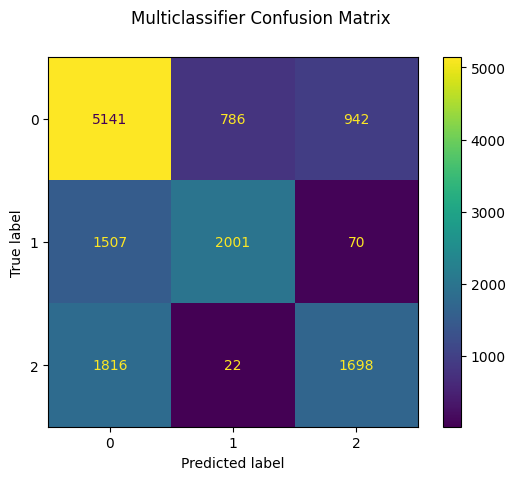

In [91]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(save_dir+'/images/' + qmodel_prefix + '_confusionMatrix.png')
plt.show()

In [92]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + qmodel_type + '_' + chosen_qmodel, pt_data)

FileNotFoundError: [Errno 2] No such file or directory: './csv/tmp_padded_noscaling_qkeras_foldbatchnorm_d58w4a8_true.csv'

In [ ]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0, '<<<')
print('---')

In [ ]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + qmodel_type + '_' + chosen_qmodel, pt_data)

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

In [ ]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [ ]:
print_results(results_filename)

In [ ]:
print_avg_results(results_filename)

In [ ]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )

In [ ]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

In [ ]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q='QKeras y-local = {}'.format(local_id), predict_data_q='csv/' + qmodel_prefix + '_predictionsFiles.csv', true_data_q='csv/' + qmodel_prefix + '_true.csv',
               label_h=None, predict_data_h=None, true_data_h=None,
               output_image='images/' + model_prefix + '_turnonCurve.png',
               base_dir='.')

## Hardware translation

### hls4ml configuration

#### Setup

In [93]:
import hls4ml
# import plotting

hmodel_prefix = dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel

In [94]:
print('------------------------------------')
print(hmodel_prefix)
print('------------------------------------')

------------------------------------
tmp_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8
------------------------------------


In [95]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.1.0.dev1502+g4a56d6e


In [96]:
import os
os.environ['PATH'] = '/fpga/cad/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is NOT in the PATH
-----------------------------------


In [97]:
import os

print('-----------------------------------')
if os.environ.get('MGC_HOME') is not None and is_tool('catapult'):
    print('Siemens Catapult HLS is configured')
else:
    print('Siemens Catapult HLS is NOT configured')
print('-----------------------------------')

-----------------------------------
Siemens Catapult HLS is NOT configured
-----------------------------------


In [98]:
input_size = 6

In [99]:
# hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
     layers=['Activation'],
     rounding_mode='AP_RND_CONV',
     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

# programmable weights (weights on the interface)
hconfig["Model"]["BramFactor"] = 0

# set bitwidth of the input features
hconfig['LayerName']['input1']['Precision']['result'] = 'ufixed<' + str(input_size) + ',' + str(input_size) + '>'

# enable tracing
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True

# #1
# hconfig['Model']['Precision'] = 'ap_fixed<16,8>'    

# # 2
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<12,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<12,6>'

# # 3
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'

# # 4
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'

# # 5
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,6>'

# # 6
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,5>'

# # 7
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<9,5>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<9,5>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<9,5>'

# # 8
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 9
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 10
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 11
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# 12
hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# Dense
#hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<8,5>'
#hconfig['LayerName']['dense1']['Precision']['default'] = 'ap_fixed<8,5>'
# ReLU
#hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<8,0,AC_RND_CONV,AC_SAT>'
# Dense
#hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# SoftMax
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'
#hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'
# Required for the folding of BatchNormalization
#hconfig['SkipOptimizers'] = ['propagate_dense_precision']    
#hconfig['LayerName']['dense1_linear']['Trace'] = True
#hconfig['LayerName']['dense2_linear']['Trace'] = True

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]


#### Convert

In [100]:
plotting.print_dict(hconfig)

NameError: name 'plotting' is not defined

In [101]:
!rm -rf $hmodel_prefix\_$run_id\_catapult_prj*

In [102]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=save_dir+'/qmodel_0_catapult_prj',
                                                    # output_dir=save_dir+'/qmodel_' + str(run_id) + '_catapult_prj',  # commented because all models are stored in separate folders per run_id
                                                    backend='Catapult',
                                                    #output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    #backend='Vivado',
                                                    part='XC7A100T')

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model


In [103]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=save_dir+'/model.png')

### Bit-accurate simulation

In [104]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test.astype(float)))

Recompiling myproject with tracing
Writing HLS project


/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
ERROR: Variable MGC_HOME is not defined. Sourcing the Siemens Catapult scripts should fix this.


build_lib.sh: line 5: return: can only `return' from a function or sourced script
g++: error: unrecognized command line option '-std=c++17'
g++: error: unrecognized command line option '-std=c++17'
g++: error: myproject.o: No such file or directory
g++: error: myproject_bridge.o: No such file or directory
g++: error: unrecognized command line option '-std=c++17'
g++: fatal error: no input files
compilation terminated.


OSError: tmp_NoiseXe-/noiseTrainedModels/model0/qmodel_0_catapult_prj/firmware/myproject-53e942BE.so: cannot open shared object file: No such file or directory

In [105]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

Processing input1 in Keras model...
Processing dense1 in Keras model...
437/437 [==============================] - 1s 917us/step
Processing relu1 in Keras model...
437/437 [==============================] - 1s 924us/step
Processing dense2 in Keras model...
437/437 [==============================] - 1s 1ms/step
Processing linear in Keras model...
437/437 [==============================] - 1s 1ms/step
Done taking outputs for Keras model.


In [106]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    if 'dense1_linear' in layer:
        continue
    if 'dense2_linear' in layer:
        continue
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join(hmodel_prefix + '_0_catapult_prj', 'profiling_{}.png'.format(layer)), dpi=300)
    # plt.savefig(os.path.join(hmodel_prefix + '_' + str(run_id) + '_catapult_prj', 'profiling_{}.png'.format(layer)), dpi=300)  # commented because all models are stored in separate folders per run_id

NameError: name 'htrace' is not defined

### Model evaluation

In [107]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=save_dir+'/qmodel_0_catapult_prj',
                                                    # output_dir=save_dir+'/qmodel_' + str(run_id) + '_catapult_prj',  # commented because all models are stored in separate folders per run_id
                                                    backend='Catapult',
                                                    #output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    #backend='Vivado',
                                                    part='XC7A100T')

hmodel.compile()

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Writing HLS project
Done
ERROR: Variable MGC_HOME is not defined. Sourcing the Siemens Catapult scripts should fix this.


build_lib.sh: line 5: return: can only `return' from a function or sourced script
g++: error: unrecognized command line option '-std=c++17'
g++: error: unrecognized command line option '-std=c++17'
g++: error: myproject.o: No such file or directory
g++: error: myproject_bridge.o: No such file or directory
g++: error: unrecognized command line option '-std=c++17'
g++: fatal error: no input files
compilation terminated.


OSError: tmp_NoiseXe-/noiseTrainedModels/model0/qmodel_0_catapult_prj/firmware/myproject-1DceEDE5.so: cannot open shared object file: No such file or directory

In [108]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test.astype(float)))
np.savetxt('tb_output_predictions_hw.dat', hpreds, fmt='%f')

predictionsFiles = np.argmax(hpreds, axis=1)
pd.DataFrame(predictionsFiles).to_csv(save_dir+"/csv/" + hmodel_prefix + "_predictionsFiles.csv", header='predict', index=False)
pd.DataFrame(y_test).to_csv(save_dir+'/csv/' + hmodel_prefix + '_true.csv', header='true', index=False)

Exception: Model not compiled

In [109]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

-----------------------------------


NameError: name 'y_test_oh' is not defined

In [ ]:
hls4ml_accuracy = accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))

In [ ]:
def get_number_of_tracks(model_label, pt_data, base_dir = '.'):
    import numpy as np
    import pandas as pd
    
    print(base_dir + '/csv/' + model_label + '_true.csv')
    print(base_dir + '/csv/' + model_label + '_predictionsFiles.csv')
    print(base_dir + '/csv/' + model_label + '_concatenatedSample.csv')
    print()
    df1 = pd.read_csv(base_dir + '/csv/' + model_label + '_true.csv')
    headers =  ["true"]
    df1.columns = headers
    df2 = pd.read_csv(base_dir + '/csv/' + model_label + '_predictionsFiles.csv')
    headers =  ["predicted"]
    df2.columns = headers
    df3 = pd.concat([df1,df2],  axis=1, join="inner")
    dfPT = pd.read_csv(pt_data)
    df5 = pd.concat([df1,df2,dfPT],  axis=1, join="inner")
    df5.to_csv(base_dir + '/csv/' + model_label + '_concatenatedSample.csv',index=False)
    
    df6=pd.read_csv(base_dir + '/csv/' + model_label + '_concatenatedSample.csv')
    
    display(df6)
    
    df7 = df6.loc[ (df6['pt'] > 0.2) | (df6['pt'] < -0.2)]
    totalNumberRowsSelected = df7.shape[0] 
    predictedCorrect = df7.loc[ df7['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT = predictedCorrect.shape[0] #first number is number of rows
    newAccuracyMetric = numberCorrectlyPredictedAsHighPT/totalNumberRowsSelected
    
    df8 = df6.loc[ (df6['pt'] > 0.5) | (df6['pt'] < -0.5)]
    totalNumberRowsSelected_halfGeV = df8.shape[0] 
    predictedCorrect_halfGeV = df8.loc[ df8['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_halfGeV = predictedCorrect_halfGeV.shape[0] #first number is number of rows
    newAccuracyMetric_halfGeV = numberCorrectlyPredictedAsHighPT_halfGeV/totalNumberRowsSelected_halfGeV
    
    df9 = df6.loc[ (df6['pt'] > 1) | (df6['pt'] < -1)]
    totalNumberRowsSelected_1GeV = df9.shape[0] 
    predictedCorrect_1GeV = df9.loc[df9['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_1GeV = predictedCorrect_1GeV.shape[0] 
    newAccuracyMetric_1GeV = numberCorrectlyPredictedAsHighPT_1GeV/totalNumberRowsSelected_1GeV

    df10 = df6.loc[ (df6['pt'] > 2) | (df6['pt'] < -2)]
    totalNumberRowsSelected_2GeV = df10.shape[0] 
    predictedCorrect_2GeV = df10.loc[df10['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_2GeV = predictedCorrect_2GeV.shape[0] 
    newAccuracyMetric_2GeV = numberCorrectlyPredictedAsHighPT_2GeV/totalNumberRowsSelected_2GeV

    return (newAccuracyMetric, newAccuracyMetric_halfGeV, newAccuracyMetric_1GeV, newAccuracyMetric_2GeV)

GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel, pt_data)

In [ ]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel, pt_data)

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

In [ ]:
results_filename = 'csv/results.csv'
write_results(results_filename, hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [ ]:
print_results(results_filename)

In [ ]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    #'qkeras_foldbatchnorm_d58w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )
print(id_ordering)

In [ ]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

In [ ]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q='QKeras y-local = {}'.format(local_id), predict_data_q='csv/' + qmodel_prefix + '_predictionsFiles.csv', true_data_q='csv/' + qmodel_prefix + '_true.csv',
               label_h='hls4ml y-local = {}'.format(local_id), predict_data_h='csv/' + hmodel_prefix + '_predictionsFiles.csv', true_data_h='csv/' + hmodel_prefix + '_true.csv',
               output_image='images/' + hmodel_prefix + '_turnonCurve.png',
               base_dir='.')

### Synthesis